In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf;
from tqdm import tqdm
import time

In [2]:
path = os.getcwd()
path

'/home/laurens/Sync/Master Data Science and Entrepreneurship/Master DSE/Thesis/ente/Dev/own repos/Face Recognition'

In [3]:
# To speed up the notebook, set this value to True to skip intermediate demo steps and only run full pipeline at the end of this notebook
skip_intermediate_demo = True

## Load data

LFW subset locally downloaded

In [4]:
# download full dataset
# !download_lfw.sh

In [5]:
use_full_dataset = False
if use_full_dataset:
    dataset = 'lfw_original' # crashes the kernel, try in Paperspace/LambdaLabs/Colab!
else:
    # dataset = 'lfw_30classes_20images'
    dataset = 'lfw_30classes_2images'
    # dataset = 'lfw_10images'
data_path = path + '/data/' + dataset + '/'

In [6]:
# Load the subset data into a NumPy array
data = []
original_images = []
targets = []
targets = []
for subdir in os.listdir(data_path):
    subdir_path = os.path.join(data_path, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                img = cv2.imread(file_path, cv2.IMREAD_COLOR)
                RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append(RGB_img.flatten())
                original_images.append(RGB_img)
                targets.append(subdir)

data = np.array(data)
original_images = np.array(original_images)

### Explore data

In [7]:
original_images.shape

(116, 250, 250, 3)

In [8]:
# introspect the images arrays to find the shapes (for plotting)
n, w, h, c = original_images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = data
n_features = X.shape[1]

# the label to predict is the id of the person
target_names = targets
target_names_unique = [target_name for target_name in set(target_names)]
y = LabelEncoder().fit_transform(target_names.copy())
target_names_first_index = [np.where(y == label)[0][0] for label in np.unique(y)]
target_names_first_index.sort()

n_classes = len(target_names_unique)

subdir_counts = {subdir: targets.count(subdir) for subdir in set(targets)}
n_classes_smaller_than_5 = len([count for count in subdir_counts.values() if count < 5])
n_classes_larger_than_5 = len([count for count in subdir_counts.values() if count >= 5])
n_classes_larger_than_10 = len([count for count in subdir_counts.values() if count >= 10])
n_images_from_classes_smaller_than_5 = sum([count for count in subdir_counts.values() if count < 5])
n_images_from_classes_smaller_than_10 = sum([count for count in subdir_counts.values() if count < 10])

In [48]:
# Print the shape of the data array
print('Data shape:', data.shape)

# Print the list of subdirectories and the number of images per subdirectory
print('Subdirectory counts (unordered):', subdir_counts,'\n')

print(f"There are {n} images in the dataset, {13233 - n} less than the original dataset (of 13233).")
print(f"Each image is {w} pixels wide and {h} pixels tall, with {c} channels (RGB).")
print(f"In total this gives us {n_features} features per image.")
print(f"There are {n_classes} unique targets (classes) in the dataset, of which {n_classes_smaller_than_5} have less than 5 images, {n_classes_larger_than_5} have at least five images, and {n_classes_larger_than_10} have at least ten images.")
print(f"There are {n_images_from_classes_smaller_than_5} images from classes with less than five images, and {n_images_from_classes_smaller_than_10} images from classes with less than ten images.")

Data shape: (116, 187500)
Subdirectory counts (unordered): {'Aitor_Gonzalez': 2, 'Abdullah_al-Attiyah': 3, 'Abel_Pacheco': 4, 'Akbar_Hashemi_Rafsanjani': 3, 'Aaron_Peirsol': 4, 'Ahmet_Necdet_Sezer': 2, 'Adolfo_Rodriguez_Saa': 2, 'Abid_Hamid_Mahmud_Al-Tikriti': 3, 'Ahmad_Masood': 2, 'Aaron_Sorkin': 2, 'Aicha_El_Ouafi': 3, 'Adel_Al-Jubeir': 3, 'Abdullah_Gul': 19, 'Adam_Scott': 2, 'Adrien_Brody': 12, 'Abdel_Nasser_Assidi': 2, 'Adrian_McPherson': 2, 'Ai_Sugiyama': 5, 'Abdullatif_Sener': 2, 'Akhmed_Zakayev': 3, 'Alan_Mulally': 2, 'Abdoulaye_Wade': 4, 'Adrian_Nastase': 2, 'Ahmed_Chalabi': 5, 'Abdullah': 4, 'Alan_Ball': 2, 'Alastair_Campbell': 5, 'Adolfo_Aguilar_Zinser': 3, 'Alan_Greenspan': 5, 'Adam_Sandler': 4} 

There are 116 images in the dataset, 13117 less than the original dataset (of 13233).
Each image is 250 pixels wide and 250 pixels tall, with 3 channels (RGB).
In total this gives us 187500 features per image.
There are 30 unique targets (classes) in the dataset, of which 24 have l

In [10]:
original_images.shape

(116, 250, 250, 3)

In [11]:
if not skip_intermediate_demo:
    plot_images = original_images[target_names_first_index[0:10]]
    label_array = np.array(target_names)[target_names_first_index[0:10]]

    # Create a figure with a 2x5 grid of subplots
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    # Iterate over the subplots and plot each image with its corresponding label
    for i, ax in enumerate(axes.flat):
        ax.imshow(plot_images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(label_array[i]))

    # Show the figure
    plt.show()

In [12]:
def plot_original_faces(indices, max_faces=None, start=0):
    # Get the relevant images from the original_images array
    relevant_images = original_images[indices[start:]]
    
    # If max_faces is set, limit the number of images to plot
    if max_faces is not None:
        relevant_images = relevant_images[:max_faces]
    
    # Determine the number of rows and columns to use in the plot
    num_images = relevant_images.shape[0]
    num_cols = min(num_images, 5)
    num_rows = int(np.ceil(num_images / num_cols))
    
    # Create the plot and add subplots for each image
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axs = axs.flatten()
    for i, img in enumerate(relevant_images):
        axs[i].imshow(img)
        axs[i].axis('off')
    
    # Remove any unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

## Preprocess the images

## Face detection
Based on BlazeFace, taken inspiration from [this repo](https://github.com/ibaiGorordo/BlazeFace-TFLite-Inference). 

In [13]:
from importlib import reload
from src.blazeface import BlazeFace, BlazeFaceResults
# reload(src.BlazeFace.BlazeFace)
# reload(BlazeFaceResults)

In [14]:
blazeface_model = BlazeFace(model_type='sparse')
blazeface_model.input_details

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([  1, 192, 192,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [15]:
original_test_image = original_images[0]
face_detection_results = blazeface_model.detect_faces(original_test_image)

In [16]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)

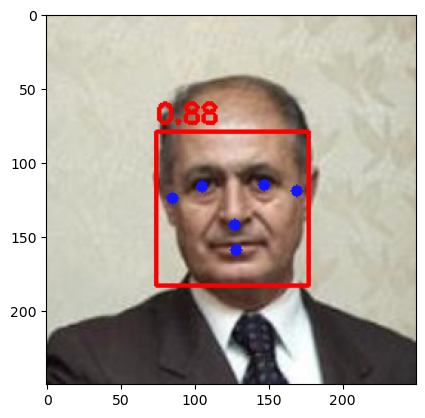

In [17]:
plot_test_image = blazeface_model.draw_detections_single_image(original_test_image, face_detection_results)
plt.imshow(plot_test_image)

#### Test detections

In [18]:
if not skip_intermediate_demo:
    blazeface_dense_model = BlazeFace(model_type='dense', score_threshold=0.6)

    face_detection_results = []
    detected_faces_count = 0
    detected_faces_indices = []
    undetected_faces_count = 0
    undetected_faces_indices = []
    double_detected_faces_count = 0
    double_detected_faces_indices = []

    for i in tqdm(range(original_images.shape[0])):
        face_detection_results.append(blazeface_dense_model.detect_faces(original_images[i]))
        if face_detection_results[-1].boxes.shape[0] > 0:
            detected_faces_count += 1
            detected_faces_indices.append(i)
            if face_detection_results[-1].boxes.shape[0] > 1:
                double_detected_faces_count += 1
                double_detected_faces_indices.append(i)

        else:
            undetected_faces_count += 1
            undetected_faces_indices.append(i)

    print(f"For the dense model:")
    print(f"Detected faces: {detected_faces_count} out of {original_images.shape[0]} ({detected_faces_count/original_images.shape[0]*100:.2f}%). Undetected faces: {undetected_faces_count} out of {original_images.shape[0]} ({undetected_faces_count/original_images.shape[0]*100:.2f}%).")
    print(f"Double detected faces: {double_detected_faces_count} out of {original_images.shape[0]} ({double_detected_faces_count/original_images.shape[0]*100:.2f}%).")

In [19]:
if not skip_intermediate_demo:
    blazeface_model = BlazeFace(model_type='sparse', score_threshold=0.6)

    face_detection_results = []
    detected_faces_count = 0
    detected_faces_indices = []
    undetected_faces_count = 0
    undetected_faces_indices = []
    double_detected_faces_count = 0
    double_detected_faces_indices = []

    for i in tqdm(range(original_images.shape[0])):
        face_detection_results.append(blazeface_model.detect_faces(original_images[i]))
        if face_detection_results[-1].boxes.shape[0] > 0:
            detected_faces_count += 1
            detected_faces_indices.append(i)
            if face_detection_results[-1].boxes.shape[0] > 1:
                double_detected_faces_count += 1
                double_detected_faces_indices.append(i)

        else:
            undetected_faces_count += 1
            undetected_faces_indices.append(i)

    print(f"Detected faces: {detected_faces_count} out of {original_images.shape[0]} ({detected_faces_count/original_images.shape[0]*100:.2f}%). Undetected faces: {undetected_faces_count} out of {original_images.shape[0]} ({undetected_faces_count/original_images.shape[0]*100:.2f}%).")
    print(f"Double detected faces: {double_detected_faces_count} out of {original_images.shape[0]} ({double_detected_faces_count/original_images.shape[0]*100:.2f}%).")

## Face Alignment

In [20]:
from src.face_alignment import ArcFaceAlignment

In [21]:
def plot_aligned_faces(aligned_face_results_list, max_faces=None, indices=None, start=0):
    if indices is not None:
        aligned_face_results_list = [aligned_face_results_list[i] for i in indices]

    aligned_faces = [
        face
        for aligned_face_results in aligned_face_results_list
        if aligned_face_results is not None
        for face in aligned_face_results.aligned_faces
    ]

    if start > 0:
        aligned_faces = aligned_faces[start:]

    if max_faces is not None:
        aligned_faces = aligned_faces[:max_faces]

    num_faces = len(aligned_faces)
    cols = min(5, num_faces)
    rows = int(np.ceil(num_faces / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    fig.suptitle("Aligned Faces", fontsize=20, y=1.02)

    for i, ax in enumerate(axes.flat):
        if i < num_faces:
            if aligned_faces[i].shape[-1] == 3:
                ax.imshow(aligned_faces[i].astype(np.uint8))
            else:
                ax.imshow(aligned_faces[i], cmap='gray')
            ax.set_title(f"Face {i + 1 + start}")

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [22]:
test_image = original_images[25]
test_image_face_detection_result = blazeface_model.detect_faces(test_image)
arcface_align = ArcFaceAlignment()
test_image_align_result = arcface_align.crop_and_align(test_image, test_image_face_detection_result)
image, face_detection_result = test_image, test_image_face_detection_result
test_image_align_result

AlignedFaceResults(
  num_faces=1,  # Number of detected faces
  eye_coordinates=None,  # (Left eye, Right eye)(from viewer perspective) coordinates for each face (x,y)
  rotation_angles=None,  # Rotation angles for each face alignment
  relative_face_sizes=[0.200704]  # Relative size of each face compared to the original image
)

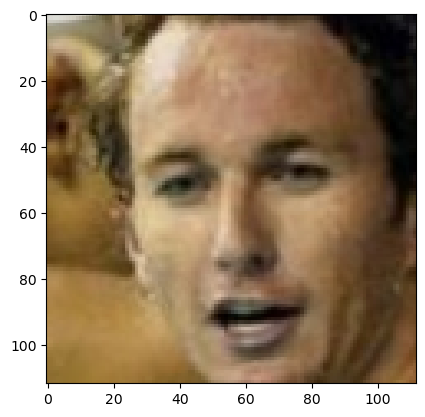

In [23]:
plt.imshow(test_image_align_result.aligned_faces[0])

## Face embeddings

In [24]:
from src.mobilefacenet import MobileFaceNet

In [25]:
mobilefacenet_model = MobileFaceNet(model_type="ente_web")
# mobilefacenet_quantized_model = MobileFaceNet(model_type="quantized")

In [26]:
mobilefacenet_model.interpreter.get_input_details()

[{'name': 'input',
  'index': 369,
  'shape': array([  1, 112, 112,   3], dtype=int32),
  'shape_signature': array([  1, 112, 112,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [27]:
mobilefacenet_model.interpreter.get_output_details()

[{'name': 'embeddings',
  'index': 368,
  'shape': array([  1, 192], dtype=int32),
  'shape_signature': array([  1, 192], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [28]:
# run face detection and alignment/normalization on all images again
if not skip_intermediate_demo:
    face_detection_results = []
    face_alignment_results = []
    # face_normalization_results = []

    for idx in tqdm(range(original_images.shape[0])):
        image = original_images[idx]
        face_detection_results.append(blazeface_model.detect_faces(image))
        if face_detection_results[-1].boxes.shape[0] > 0:
            face_alignment_results.append(arcface_align.crop_and_align(image, face_detection_results[idx]))
            # face_normalization_results.append(face_mesh_model.normalize_faces(image, face_detection_results[idx]))
        else:
            face_alignment_results.append(None)
            # face_normalization_results.append(None)

In [29]:
# create face embeddings using MobileFaceNet model
if not skip_intermediate_demo:
    face_embeddings = []
    # face_embeddings_normalized = []

    for idx in tqdm(range(original_images.shape[0])):
        if (face_alignment_results[idx] is not None): # if face was detected
            if (face_alignment_results[idx].num_faces ==1): # if only one face was detected
                face_embeddings.append(mobilefacenet_model.extract_embedding(face_alignment_results[idx].aligned_faces[0]))
            else:
                face_embeddings.append(None)
        else:
            face_embeddings.append(None)
        # if (face_normalization_results[idx] is not None): # if face was detected
        #     if (face_normalization_results[idx].num_faces ==1): # if only one face was detected
        #         face_embeddings_normalized.append(mobilefacenet_model.extract_embedding(face_normalization_results[idx].aligned_faces[0]))
        face_embeddings_squeezed = [array[0] if array is not None else None for array in face_embeddings] # squeeze the embeddings to remove the extra dimension

## Indexing the embeddings

### Quick approach with pandas

In [30]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from collections import Counter

In [31]:
if not skip_intermediate_demo:
    face_embeddings_used = face_embeddings

    # filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings) if arr is not None]
    filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings_used) if arr is not None]

    # Separate indices and data into two lists
    original_indices, filtered_data_arrays = zip(*filtered_embeddings)
    minimum_cluster_size_general = 5
    true_labels = y[np.array(original_indices)]
    label_counts = Counter(true_labels)
    label_map = {label: label if count >= minimum_cluster_size_general else -1 for label, count in label_counts.items()}
    true_labels_with_noise = np.vectorize(label_map.get)(true_labels)
    # Create a pandas DataFrame from the data arrays
    df_embeddings = pd.DataFrame(filtered_data_arrays)

    # Add the original index column
    df_embeddings['original_index'] = original_indices

    # Calculate the cosine distance matrix
    temp = time.time()
    cosine_dist_matrix = cosine_distances(df_embeddings.drop(columns=['original_index'])).astype(np.float64)
    cosine_distance_time = time.time() - temp
    temp = time.time()
    cosine_dist_matrix_more_precise = pairwise_distances(df_embeddings.drop(columns=['original_index']), metric='cosine').astype(np.float64)
    cosine_pairwise_distance_time = time.time() - temp

    norm_data = normalize(df_embeddings.drop(columns=['original_index']), norm='l2', axis=1)

In [32]:
if not skip_intermediate_demo:
    df_embeddings

## Clustering

### DBSCAN clustering

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

In [34]:
# Perform DBSCAN clustering
if not skip_intermediate_demo:
    # test parameters
    dbscan_epsilon = 0.3
    dbscan_min_samples = 5 

    # default parameters
    # dbscan_epsilon = 0.5 # 0.5 is default
    # dbscan_min_samples = 5 # 5 is default (integer values only)

    temp = time.time()
    dbscan = DBSCAN(eps=dbscan_epsilon, min_samples=dbscan_min_samples, metric='precomputed')
    cluster_labels_dbscan = dbscan.fit_predict(cosine_dist_matrix)
    dbscan_time = time.time() - temp

    # Add the cluster labels as a new column in the DataFrame
    df_embeddings['dbscan_cluster_label'] = cluster_labels_dbscan

In [35]:
if not skip_intermediate_demo:
    number_clusters_dbscan = len(np.unique(cluster_labels_dbscan))-1
    ari_dbscan = adjusted_rand_score(true_labels_with_noise, cluster_labels_dbscan)
    ari_dbscan_exnoise = adjusted_rand_score(true_labels_with_noise[cluster_labels_dbscan != -1], cluster_labels_dbscan[cluster_labels_dbscan != -1])
    ami_dbscan = adjusted_mutual_info_score(true_labels_with_noise, cluster_labels_dbscan)
    ami_dbscan_exnoise = adjusted_mutual_info_score(true_labels_with_noise[cluster_labels_dbscan != -1], cluster_labels_dbscan[cluster_labels_dbscan != -1])
    percentage_noise_dbscan = np.sum(cluster_labels_dbscan==-1)/len(cluster_labels_dbscan)*100

In [36]:
if not skip_intermediate_demo:
    print(f"Results for the DBSCAN clustering:\n")

    print(f"Number of different clusters: {number_clusters_dbscan}")
    print(f"ARI score for clustering accuracy: {ari_dbscan:.4f}")
    print(f"ARI score excluding noise: {ari_dbscan_exnoise:.4f}")
    print(f"AMI score for clustering accuracy: {ami_dbscan:.4f}")
    print(f"AMI score excluding noise: {ami_dbscan_exnoise:.4f}")
    print(f"Percentage of faces clustered into noise: {percentage_noise_dbscan:.2f}%")
    print(f"Time taken for DBSCAN clustering: {dbscan_time:.2f}s")

To easily interpret ARI:
The Adjusted Rand Index (ARI) measures the similarity between two clusterings, with 1 indicating a perfect match and 0 implying agreement no better than random chance. A higher ARI value signifies greater similarity between the two clusterings, while a negative value indicates the agreement is worse than random chance.

In [37]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

In [38]:
def plot_tsne_clusters(distance_matrix, labels, figsize=(10, 8), n_components=2, metric='precomputed', init='random', random_state=42, perplexity = 30.0):
    # Perform t-SNE on the embeddings
    tsne = TSNE(n_components=n_components, metric=metric, init=init, random_state=random_state, perplexity=perplexity)
    embeddings_2d = tsne.fit_transform(distance_matrix)

    # Add the 2D embeddings to a DataFrame
    df_embeddings = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'cluster_label': labels})

    # Define the colormap
    n_clusters = len(np.unique(labels))
    if n_clusters <= 10:
        tab10_cmap = plt.get_cmap('tab10', np.unique(labels).size - 1)
        tab10_cmap_list = tab10_cmap(np.linspace(0, 1, np.unique(labels).size - 1))
        custom_cmap_list = np.vstack(([0.7, 0.7, 0.7, 1.], tab10_cmap_list))
        cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', custom_cmap_list)
    else:
        cmap = plt.get_cmap('nipy_spectral', np.unique(labels).size - 1)

    # Plot the clusters
    plt.figure(figsize=figsize)
    scatter = plt.scatter(df_embeddings['x'], df_embeddings['y'], c=df_embeddings['cluster_label'], cmap=cmap, s=50)
    plt.title("t-SNE visualization of clusters")

    # Add a legend for the cluster colors
    if n_clusters <= 10:
        labels = ["noise"] + [f"Cluster {i}" for i in range(1, n_clusters)]
        handles, _ = scatter.legend_elements()
        legend1 = plt.legend(handles, labels, loc="upper left", title="Clusters")
        plt.gca().add_artist(legend1)
    else:
        # Only show legend for noise
        noise_proxy = plt.scatter([], [], c='grey', s=50)
        plt.legend([noise_proxy], ["noise"], loc="upper left", title="Clusters")

    plt.show()

In [39]:
if not skip_intermediate_demo:
    plot_tsne_clusters(cosine_dist_matrix, df_embeddings['dbscan_cluster_label'])

In [40]:
if not skip_intermediate_demo:
    dbscan_noise = list(df_embeddings[df_embeddings['dbscan_cluster_label'] == -1]["original_index"].values)
    print(f"Number of faces clustered into noise: {len(dbscan_noise)} (out of {n_images_from_classes_smaller_than_5}/{n_images_from_classes_smaller_than_10} for min_samples=5/10)")
    plot_original_faces(dbscan_noise, max_faces=10)

## Evaluation

Now a proper evaluation using a sound protocol. 

Protocol:
- More than one face detected:
	- Use the largest face and continue
- No faces detected:
	- In that case the clustering is wrong for this image, so set to noise `-1`
- Person in dataset has less than x (=5) images
	- Set the ground truth for those images to noise `-1`

In [41]:
# Initializing all models
blazeface_model = BlazeFace(model_type='dense', score_threshold=0.6)
alignment_model = ArcFaceAlignment()
embedding_model = MobileFaceNet(model_type="ente_web")

In [42]:
# detection
face_detection_results = []
detected_faces_count = 0
detected_faces_indices = []
undetected_faces_count = 0
undetected_faces_indices = []
double_detected_faces_count = 0
double_detected_faces_indices = []
# alignment
face_alignment_results = []
# embedding
face_embedding_results = []

for i in tqdm(range(n)):
    face_detection_results.append(blazeface_model.detect_faces(original_images[i]))
    number_of_faces = face_detection_results[-1].get_face_count()
    if number_of_faces > 1:
        face_detection_results[-1] = face_detection_results[-1].get_largest_face()
        double_detected_faces_count += 1
        double_detected_faces_indices.append(i)
    if number_of_faces > 0:
        detected_faces_count += 1
        detected_faces_indices.append(i)
        face_alignment_results.append(alignment_model.crop_and_align(original_images[i], face_detection_results[-1]))
        face_embedding_results.append(embedding_model.extract_embedding(face_alignment_results[-1].aligned_faces[0]))
    else:
        face_detection_results[-1] = None
        face_alignment_results.append(None)
        face_embedding_results.append(None)
        undetected_faces_count += 1
        undetected_faces_indices.append(i)
face_embeddings_squeezed = [array[0] if array is not None else None for array in face_embedding_results] # squeeze the embeddings to remove the extra dimension

print(f"For the dense model:")
print(f"Detected faces: {detected_faces_count} out of {original_images.shape[0]} ({detected_faces_count/original_images.shape[0]*100:.2f}%). Undetected faces: {undetected_faces_count} out of {original_images.shape[0]} ({undetected_faces_count/original_images.shape[0]*100:.2f}%).")
print(f"Double detected faces: {double_detected_faces_count} out of {original_images.shape[0]} ({double_detected_faces_count/original_images.shape[0]*100:.2f}%).")

100%|██████████| 116/116 [00:01<00:00, 62.13it/s]

For the dense model:
Detected faces: 114 out of 116 (98.28%). Undetected faces: 2 out of 116 (1.72%).
Double detected faces: 10 out of 116 (8.62%).


In [51]:
face_embeddings_used = face_embedding_results

# filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings) if arr is not None]
filtered_embeddings = [(idx, arr[0]) for idx, arr in enumerate(face_embeddings_used) if arr is not None]

# Separate indices and data into two lists
original_indices, filtered_data_arrays = zip(*filtered_embeddings)
minimum_cluster_size_general = 5
true_labels = y[np.array(original_indices)]
label_counts = Counter(true_labels)
label_map = {label: label if count >= minimum_cluster_size_general else -1 for label, count in label_counts.items()}
# create the true labels, taking into account that some classes have less than 5 images and should be considered noise
true_labels_with_noise = np.vectorize(label_map.get)(true_labels)
# Create a pandas DataFrame from the data arrays
df_embeddings = pd.DataFrame(filtered_data_arrays)

# Add the original index column
df_embeddings['original_index'] = original_indices

# Calculate the cosine distance matrix
temp = time.time()
cosine_dist_matrix = cosine_distances(df_embeddings.drop(columns=['original_index'])).astype(np.float64)
cosine_distance_time = time.time() - temp
temp = time.time()
cosine_dist_matrix_more_precise = pairwise_distances(df_embeddings.drop(columns=['original_index']), metric='cosine').astype(np.float64)
cosine_pairwise_distance_time = time.time() - temp

norm_data = normalize(df_embeddings.drop(columns=['original_index']), norm='l2', axis=1)

In [52]:
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,original_index
0,0.000554,0.004214,0.005712,-0.003055,-0.016154,-0.065979,0.132925,0.117606,0.051986,0.049963,...,-0.003201,-0.045361,-0.058578,-0.073622,-0.062957,0.030664,0.117649,0.004715,0.002711,0
1,-0.011556,0.009290,0.006087,-0.004910,-0.021972,-0.092792,0.092181,0.036374,0.099115,0.067913,...,0.000814,0.028670,-0.073470,-0.045513,0.023737,0.088692,0.238267,-0.015301,-0.003293,1
2,-0.001928,0.006405,-0.001504,0.006276,0.001183,-0.064353,0.142866,0.007075,0.020310,0.101445,...,-0.002119,0.078464,-0.155208,-0.027239,0.027202,0.160734,0.098193,-0.010634,-0.004711,2
3,-0.002435,0.010301,0.001994,-0.007825,0.000500,-0.009865,0.092122,0.062065,-0.033254,0.070749,...,0.001443,0.023557,-0.180798,-0.029437,0.082128,0.139735,0.108737,-0.017248,-0.006947,3
4,0.004222,0.004289,-0.002656,-0.002619,0.008468,-0.025469,-0.043474,0.116519,0.020913,0.050179,...,-0.001247,0.053412,-0.241743,0.046293,0.053488,0.173413,0.162520,-0.014872,-0.013786,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-0.008141,0.002107,0.012267,-0.007274,-0.021883,0.121567,-0.076765,-0.137669,-0.026377,-0.130789,...,-0.000887,-0.239965,0.132932,-0.050429,-0.025278,-0.033094,-0.114024,0.001078,0.007739,111
110,-0.006167,-0.001676,0.008171,-0.001604,-0.008465,0.029174,-0.049031,0.013738,-0.041850,-0.097865,...,-0.002917,-0.116029,0.238464,0.044241,-0.035497,-0.138399,-0.013825,0.005654,0.011888,112
111,-0.010220,-0.005198,0.006335,0.001857,-0.006183,0.129856,-0.036078,-0.116401,-0.127423,-0.194582,...,-0.003654,-0.188923,0.240939,0.004961,-0.042210,-0.051352,-0.122351,0.008779,0.015755,113
112,-0.012552,0.006335,0.019734,0.011923,-0.020761,0.157186,-0.002450,0.050710,-0.159501,0.050011,...,0.002571,-0.000591,-0.021809,0.068457,0.069167,-0.147171,-0.014090,-0.035351,0.004984,114


In [54]:
# Perform DBSCAN clustering

# test parameters
dbscan_epsilon = 0.3
dbscan_min_samples = minimum_cluster_size_general 

# default parameters
# dbscan_epsilon = 0.5 # 0.5 is default
# dbscan_min_samples = 5 # 5 is default (integer values only)

temp = time.time()
dbscan = DBSCAN(eps=dbscan_epsilon, min_samples=dbscan_min_samples, metric='precomputed')
cluster_labels_dbscan = dbscan.fit_predict(cosine_dist_matrix)
dbscan_time = time.time() - temp

# Add the cluster labels as a new column in the DataFrame
df_embeddings['dbscan_cluster_label'] = cluster_labels_dbscan

In [57]:
true_labels_with_noise

array([-1, -1, -1, -1, -1, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5, -1, -1, -1, -1, 29, 29, 29, 29, 29, 19,
       19, 19, 19, 19, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       27, 27, 27, 27, 27, 21, 21, 21, 21, 21, -1, -1])

In [58]:
cluster_labels_dbscan

array([-1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,
        2,  2,  2,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4, -1, -1])

In [61]:
number_clusters_dbscan = len(np.unique(cluster_labels_dbscan))-1
ari_dbscan = adjusted_rand_score(true_labels_with_noise, cluster_labels_dbscan)
ari_dbscan_exnoise = adjusted_rand_score(true_labels_with_noise[cluster_labels_dbscan != -1], cluster_labels_dbscan[cluster_labels_dbscan != -1])
arr_dbscan_extruenoise = adjusted_rand_score(true_labels_with_noise[true_labels_with_noise != -1], cluster_labels_dbscan[true_labels_with_noise != -1])
ami_dbscan = adjusted_mutual_info_score(true_labels_with_noise, cluster_labels_dbscan)
ami_dbscan_exnoise = adjusted_mutual_info_score(true_labels_with_noise[cluster_labels_dbscan != -1], cluster_labels_dbscan[cluster_labels_dbscan != -1])
ami_dbscan_extruenoise = adjusted_mutual_info_score(true_labels_with_noise[true_labels_with_noise != -1], cluster_labels_dbscan[true_labels_with_noise != -1])
hcv_dbscan = homogeneity_completeness_v_measure(true_labels_with_noise, cluster_labels_dbscan)
percentage_noise_dbscan = np.sum(cluster_labels_dbscan==-1)/len(cluster_labels_dbscan)*100

In [62]:
hcv_dbscan

(0.8565539304671423, 0.9723693082905205, 0.910794652538418)

In [63]:
print(f"Results for the DBSCAN clustering:\n")

print(f"Number of different clusters: {number_clusters_dbscan}")
print(f"ARI score for clustering accuracy: {ari_dbscan:.4f}")
print(f"ARI score excluding noise: {ari_dbscan_exnoise:.4f}")
print(f"ARI score excluding true noise: {arr_dbscan_extruenoise:.4f}")
print(f"AMI score for clustering accuracy: {ami_dbscan:.4f}")
print(f"AMI score excluding noise: {ami_dbscan_exnoise:.4f}")
print(f"AMI score excluding true noise: {ami_dbscan_extruenoise:.4f}")
print(f"Percentage of faces clustered into noise: {percentage_noise_dbscan:.2f}%")
print(f"Time taken for DBSCAN clustering: {dbscan_time:.2f}s")

Results for the DBSCAN clustering:

Number of different clusters: 5
ARI score for clustering accuracy: 0.8676
ARI score excluding noise: 1.0000
ARI score excluding true noise: 0.9460
AMI score for clustering accuracy: 0.9009
AMI score excluding noise: 1.0000
AMI score excluding true noise: 0.9516
Percentage of faces clustered into noise: 60.53%
Time taken for DBSCAN clustering: 0.00s


To easily interpret ARI:
The Adjusted Rand Index (ARI) measures the similarity between two clusterings, with 1 indicating a perfect match and 0 implying agreement no better than random chance. A higher ARI value signifies greater similarity between the two clusterings, while a negative value indicates the agreement is worse than random chance.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

In [ ]:
def plot_tsne_clusters(distance_matrix, labels, figsize=(10, 8), n_components=2, metric='precomputed', init='random', random_state=42, perplexity = 30.0):
    # Perform t-SNE on the embeddings
    tsne = TSNE(n_components=n_components, metric=metric, init=init, random_state=random_state, perplexity=perplexity)
    embeddings_2d = tsne.fit_transform(distance_matrix)

    # Add the 2D embeddings to a DataFrame
    df_embeddings = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'cluster_label': labels})

    # Define the colormap
    n_clusters = len(np.unique(labels))
    if n_clusters <= 10:
        tab10_cmap = plt.get_cmap('tab10', np.unique(labels).size - 1)
        tab10_cmap_list = tab10_cmap(np.linspace(0, 1, np.unique(labels).size - 1))
        custom_cmap_list = np.vstack(([0.7, 0.7, 0.7, 1.], tab10_cmap_list))
        cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', custom_cmap_list)
    else:
        cmap = plt.get_cmap('nipy_spectral', np.unique(labels).size - 1)

    # Plot the clusters
    plt.figure(figsize=figsize)
    scatter = plt.scatter(df_embeddings['x'], df_embeddings['y'], c=df_embeddings['cluster_label'], cmap=cmap, s=50)
    plt.title("t-SNE visualization of clusters")

    # Add a legend for the cluster colors
    if n_clusters <= 10:
        labels = ["noise"] + [f"Cluster {i}" for i in range(1, n_clusters)]
        handles, _ = scatter.legend_elements()
        legend1 = plt.legend(handles, labels, loc="upper left", title="Clusters")
        plt.gca().add_artist(legend1)
    else:
        # Only show legend for noise
        noise_proxy = plt.scatter([], [], c='grey', s=50)
        plt.legend([noise_proxy], ["noise"], loc="upper left", title="Clusters")

    plt.show()

In [ ]:
if not skip_intermediate_demo:
    plot_tsne_clusters(cosine_dist_matrix, df_embeddings['dbscan_cluster_label'])

In [ ]:
if not skip_intermediate_demo:
    dbscan_noise = list(df_embeddings[df_embeddings['dbscan_cluster_label'] == -1]["original_index"].values)
    print(f"Number of faces clustered into noise: {len(dbscan_noise)} (out of {n_images_from_classes_smaller_than_5}/{n_images_from_classes_smaller_than_10} for min_samples=5/10)")
    plot_original_faces(dbscan_noise, max_faces=10)